In [91]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='serif')
%matplotlib inline

import os, re, string, itertools

from recording import Recording
from neural_net import MultiLayerPerceptron
from auxiliary import *

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import keras 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dh = DataHandler()

In [3]:
def train_test_split(df,speaker_id):
    X_train = np.stack(df[df.speaker_id != speaker_id].feature_vec.tolist())
    y_train = df[df.speaker_id != speaker_id].emotion_label.tolist()
    X_test = np.stack(df[df.speaker_id == speaker_id].feature_vec.tolist())
    y_test = df[df.speaker_id == speaker_id].emotion_label.tolist()
    return X_train, X_test, y_train, y_test

# Condition 1
- Global features (averaged features over time)
- Train a single classifier

In [4]:
df_1 = dh.build_feature_data(condition=1)

Excluded 08a01Ab (empty tag-file)
Excluded 08a01Wa (empty tag-file)



In [5]:
df_1.head()

,ID,feature_vec,sex,speaker_id,age,emotion_name,emotion_label
0,03a01Fa,"[-281.7693789658906, 115.77593080338801, -34.6...",m,03,31,happiness,4
1,03a01Nc,"[-265.01092879111286, 143.43997488641665, -29....",m,03,31,neutral,5
2,03a01Wa,"[-231.12855862566673, 92.83604677664029, -65.2...",m,03,31,anger,2
3,03a02Fc,"[-258.335947603345, 89.06959007175533, -35.515...",m,03,31,happiness,4
4,03a02Nc,"[-246.59932119184973, 133.65802155226476, -22....",m,03,31,neutral,5


In [198]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

In [200]:
df_scores_1 = pd.DataFrame()
for i in range(5):
    scores, cms = [],[]
    for speaker_id in tqdm(sorted(set(df_1.speaker_id))):
        X_train, X_test, y_train, y_test = train_test_split(df_1,speaker_id)
        y_train = one_hot_encode(y_train, 7)

        scl = StandardScaler().fit(X_train)
        X_train = scl.transform(X_train)
        X_test = scl.transform(X_test)

        model = MultiLayerPerceptron([61,96,32,7])
        model.fit(X_train,y_train,epochs=100,val_data=(X_test,one_hot_encode(y_test,7)),class_weight=get_class_weights(df_1.emotion_label))
        pred = model.predict(X_test)
        scores.append(accuracy_score(y_test,pred))
        cms.append(confusion_matrix(y_test,model.predict(X_test)))
    df_scores_1['score_run_%i'%(i+1)] = scores
    df_scores_1['cm_run_%i'%(i+1)] = cms
    df_scores_1['speaker'] = sorted(set(df_1.speaker_id))

df_scores_1 = df_scores_1.set_index('speaker')
df_scores_1

,score_run_1,cm_run_1,score_run_2,cm_run_2,score_run_3,cm_run_3,score_run_4,cm_run_4,score_run_5,cm_run_5
speaker,,,,,,,,,,
03,0.612245,"[[1, 0, 3, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],...",0.653061,"[[2, 0, 2, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.530612,"[[1, 0, 3, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],...",0.551020,"[[1, 0, 3, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],...",0.551020,"[[1, 0, 3, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],..."
08,0.535714,"[[3, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.589286,"[[4, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.571429,"[[3, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.571429,"[[4, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.535714,"[[3, 0, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
09,0.488372,"[[0, 0, 1, 0, 0, 0, 0], [0, 1, 5, 0, 2, 0, 0],...",0.558140,"[[0, 0, 1, 0, 0, 0, 0], [0, 3, 3, 0, 2, 0, 0],...",0.581395,"[[0, 0, 1, 0, 0, 0, 0], [0, 3, 5, 0, 0, 0, 0],...",0.488372,"[[0, 0, 1, 0, 0, 0, 0], [1, 1, 3, 0, 3, 0, 0],...",0.558140,"[[0, 0, 1, 0, 0, 0, 0], [0, 1, 5, 0, 2, 0, 0],..."
10,0.578947,"[[2, 5, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.552632,"[[2, 4, 2, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.657895,"[[5, 1, 0, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 0],...",0.710526,"[[7, 0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0],...",0.605263,"[[4, 3, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],..."
11,0.490909,"[[1, 0, 3, 1, 0, 2, 3], [0, 0, 0, 0, 0, 1, 1],...",0.509091,"[[2, 0, 1, 2, 0, 2, 3], [0, 0, 0, 0, 0, 1, 1],...",0.490909,"[[2, 0, 1, 3, 0, 2, 2], [0, 0, 0, 0, 0, 1, 1],...",0.454545,"[[1, 0, 2, 3, 0, 2, 2], [0, 0, 0, 0, 0, 1, 1],...",0.545455,"[[1, 0, 3, 2, 0, 2, 2], [0, 0, 0, 1, 0, 1, 0],..."
12,0.685714,"[[5, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2],...",0.628571,"[[4, 1, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 2],...",0.628571,"[[5, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2],...",0.628571,"[[4, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 2],...",0.714286,"[[6, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2],..."
13,0.721311,"[[2, 1, 0, 1, 0, 0, 3], [0, 6, 0, 0, 0, 1, 1],...",0.704918,"[[2, 2, 0, 0, 0, 0, 3], [0, 6, 0, 0, 0, 1, 1],...",0.655738,"[[2, 1, 0, 1, 0, 0, 3], [1, 6, 0, 0, 0, 0, 1],...",0.672131,"[[2, 1, 0, 1, 0, 0, 3], [0, 6, 0, 0, 0, 1, 1],...",0.655738,"[[2, 1, 0, 1, 0, 0, 3], [0, 6, 0, 1, 0, 0, 1],..."
14,0.565217,"[[4, 2, 0, 4, 2, 0, 0], [1, 4, 0, 0, 0, 2, 1],...",0.608696,"[[4, 1, 0, 4, 3, 0, 0], [1, 6, 0, 0, 0, 1, 0],...",0.623188,"[[4, 2, 0, 4, 2, 0, 0], [0, 6, 0, 0, 0, 1, 1],...",0.695652,"[[5, 0, 1, 4, 2, 0, 0], [1, 5, 0, 0, 0, 1, 1],...",0.608696,"[[4, 1, 0, 5, 2, 0, 0], [1, 5, 0, 0, 0, 1, 1],..."
15,0.464286,"[[4, 1, 1, 0, 0, 1, 1], [2, 3, 0, 0, 0, 0, 0],...",0.464286,"[[4, 0, 2, 0, 1, 1, 0], [2, 3, 0, 0, 0, 0, 0],...",0.464286,"[[5, 1, 1, 0, 0, 1, 0], [1, 4, 0, 0, 0, 0, 0],...",0.500000,"[[5, 1, 2, 0, 0, 0, 0], [1, 4, 0, 0, 0, 0, 0],...",0.500000,"[[4, 2, 2, 0, 0, 0, 0], [1, 4, 0, 0, 0, 0, 0],..."


# Condition 2
- Local features (features per phoneme)
- Train a single classifier

In [110]:
def aggregate_score(predictions,IDs,dh):
    pred, labels = [],[]
    for x in np.unique(IDs):
        p = [predictions[i] for i in range(len(IDs)) if IDs[i] == x] 
        p = np.mean(p,axis=0)
        pred.append(np.argmax(p))
        labels.append(dh.emotion_from_ID(x))
    return accuracy_score(pred,labels), pred, labels

In [16]:
df_2 = dh.build_feature_data(condition=2)

Excluded 08a01Ab (empty tag-file)
Excluded 08a01Wa (empty tag-file)



In [212]:
df_scores_2 = pd.DataFrame()
for i in range(5):
    scores, cms = [],[]
    for speaker_id in tqdm(sorted(set(df_2.speaker_id))):
        X_train, X_test, y_train, y_test = train_test_split(df_2,speaker_id)
        y_train = one_hot_encode(y_train, 7)
        X_train = np.squeeze(X_train)
        X_test = np.squeeze(X_test)

        scl = StandardScaler().fit(X_train)
        X_train = scl.transform(X_train)
        X_test = scl.transform(X_test)

        model = MultiLayerPerceptron([61,96,32,7])
        model.fit(X_train,y_train,epochs=200,val_data=(X_test,one_hot_encode(y_test,7)),class_weight=get_class_weights(df_2.emotion_label))

        score,predictions,labels = aggregate_score(model.predict_proba(X_test).tolist(),
                                            df_2[df_2.speaker_id == speaker_id].ID.tolist(),
                                            dh)
        scores.append(score)
        cms.append(confusion_matrix(labels,predictions))
        keras.backend.clear_session()
    df_scores_2['score_run_%i'%(i+1)] = scores
    df_scores_2['cm_run_%i'%(i+1)] = cms
    df_scores_2['speaker'] = sorted(set(df_2.speaker_id))

keras.backend.clear_session()
    
df_scores_2 = df_scores_2.set_index('speaker')
df_scores_2

,score_run_1,cm_run_1,score_run_2,cm_run_2,score_run_3,cm_run_3,score_run_4,cm_run_4,score_run_5,cm_run_5
speaker,,,,,,,,,,
03,0.428571,"[[1, 3, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.489796,"[[2, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.428571,"[[0, 4, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.469388,"[[3, 1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],...",0.469388,"[[1, 3, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],..."
08,0.500000,"[[2, 1, 0, 0, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.375000,"[[0, 4, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.428571,"[[2, 2, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.446429,"[[2, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.303571,"[[2, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
09,0.627907,"[[1, 0, 0, 0, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0],...",0.627907,"[[0, 0, 0, 1, 0, 0, 0], [0, 7, 1, 0, 0, 0, 0],...",0.581395,"[[0, 0, 0, 1, 0, 0, 0], [0, 6, 1, 0, 1, 0, 0],...",0.581395,"[[0, 0, 0, 1, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0],...",0.674419,"[[1, 0, 0, 0, 0, 0, 0], [0, 8, 0, 0, 0, 0, 0],..."
10,0.394737,"[[1, 3, 0, 0, 0, 0, 4], [0, 1, 0, 0, 0, 0, 0],...",0.421053,"[[1, 3, 0, 0, 0, 0, 4], [0, 1, 0, 0, 0, 0, 0],...",0.447368,"[[0, 3, 0, 0, 1, 0, 4], [0, 1, 0, 0, 0, 0, 0],...",0.421053,"[[1, 4, 0, 0, 0, 0, 3], [0, 1, 0, 0, 0, 0, 0],...",0.315789,"[[0, 5, 0, 0, 0, 0, 3], [0, 1, 0, 0, 0, 0, 0],..."
11,0.436364,"[[1, 0, 0, 4, 0, 1, 4], [0, 1, 0, 0, 0, 0, 1],...",0.381818,"[[0, 1, 0, 6, 0, 0, 3], [0, 1, 0, 0, 0, 0, 1],...",0.490909,"[[0, 1, 0, 4, 0, 2, 3], [0, 1, 0, 0, 0, 0, 1],...",0.327273,"[[1, 0, 0, 5, 0, 0, 4], [0, 1, 0, 0, 0, 0, 1],...",0.454545,"[[1, 0, 0, 6, 0, 0, 3], [0, 1, 0, 0, 0, 0, 1],..."
12,0.685714,"[[1, 0, 1, 0, 0, 3, 1], [0, 1, 0, 0, 0, 0, 1],...",0.685714,"[[2, 0, 0, 2, 1, 0, 1], [0, 1, 0, 1, 0, 0, 0],...",0.628571,"[[2, 0, 0, 1, 0, 1, 2], [0, 1, 0, 0, 0, 0, 1],...",0.514286,"[[1, 0, 0, 4, 0, 0, 1], [0, 0, 0, 2, 0, 0, 0],...",0.685714,"[[2, 0, 0, 2, 0, 0, 2], [0, 1, 0, 0, 0, 0, 1],..."
13,0.426230,"[[0, 1, 1, 0, 0, 0, 5], [0, 6, 0, 0, 0, 0, 2],...",0.442623,"[[1, 1, 0, 0, 0, 0, 5], [0, 6, 0, 0, 0, 0, 2],...",0.459016,"[[0, 1, 1, 0, 0, 0, 5], [0, 5, 0, 0, 0, 0, 3],...",0.393443,"[[0, 2, 1, 0, 0, 0, 4], [0, 8, 0, 0, 0, 0, 0],...",0.442623,"[[0, 2, 0, 1, 0, 0, 4], [0, 6, 0, 1, 0, 0, 1],..."
14,0.608696,"[[1, 6, 0, 2, 3, 0, 0], [0, 8, 0, 0, 0, 0, 0],...",0.579710,"[[0, 8, 0, 1, 3, 0, 0], [0, 8, 0, 0, 0, 0, 0],...",0.594203,"[[0, 8, 0, 1, 3, 0, 0], [0, 8, 0, 0, 0, 0, 0],...",0.594203,"[[0, 8, 1, 1, 2, 0, 0], [0, 8, 0, 0, 0, 0, 0],...",0.623188,"[[1, 3, 0, 4, 4, 0, 0], [0, 8, 0, 0, 0, 0, 0],..."
15,0.428571,"[[3, 1, 0, 0, 0, 0, 4], [0, 3, 0, 0, 0, 0, 2],...",0.392857,"[[3, 3, 0, 0, 0, 0, 2], [0, 5, 0, 0, 0, 0, 0],...",0.410714,"[[1, 4, 0, 0, 0, 0, 3], [0, 5, 0, 0, 0, 0, 0],...",0.428571,"[[2, 2, 0, 3, 0, 0, 1], [0, 4, 0, 1, 0, 0, 0],...",0.446429,"[[4, 0, 0, 0, 0, 0, 4], [0, 3, 0, 0, 0, 0, 2],..."


# Condition 3
- Local features (features per phoneme)
- Train one classifier per phoneme

In [22]:
valid_phonemes = list(''.join([string.ascii_letters,string.digits,'@']))
df_3 = df_2[df_2.phoneme.isin(valid_phonemes)]
common_phonemes = {phoneme: count for phoneme,count in Counter(df_3.phoneme).most_common(6)}
df_3 = df_3[df_3.phoneme.isin(common_phonemes)]
common_phonemes

{'I': 1644, 'n': 1548, 'a': 1488, 't': 1271, 'm': 913, 's': 865}

In [206]:
df_scores_3 = pd.DataFrame()
phoneme_dict = {}
for i in range(5):
    scores, cms = [],[]
    phoneme_dict['run_%i'%i] = {}
    for speaker_id in tqdm(sorted(set(df_3.speaker_id))):
        df_train = df_3[df_3.speaker_id != speaker_id]
        df_test = df_3[df_3.speaker_id == speaker_id]
        scl = StandardScaler().fit(np.squeeze(np.stack(df_train.feature_vec.tolist())))

        model_dict = {}
        phoneme_dict['run_%i'%i]['speaker_%s'%speaker_id] = {}
        for phoneme in common_phonemes:
            model = MultiLayerPerceptron([61,96,32,7])

            tmp_train = df_train[df_train.phoneme == phoneme]
            X_train = np.squeeze(np.stack(tmp_train.feature_vec.tolist()))
            y_train = one_hot_encode(tmp_train.emotion_label.tolist(),7)
            tmp = df_test[df_test.phoneme == phoneme]
            X_test = np.squeeze(np.stack(tmp.feature_vec.tolist()))
            y_test = tmp.emotion_label.tolist()

            X_train = scl.transform(X_train)
            X_test = scl.transform(X_test)

            model.fit(X_train,y_train,epochs=200,val_data=(X_test,one_hot_encode(y_test,7)),class_weight=get_class_weights(tmp_train.emotion_label))
            model_dict[phoneme] = model
            
            # evaluate only this phoneme
            ph_pred = [model_dict[row.phoneme].predict_proba(scl.transform(row.feature_vec.reshape(1,-1))) 
                       for _,row in tmp.iterrows()]
            score,predictions,labels = aggregate_score(ph_pred,
                                                   tmp.ID.tolist(),
                                                   dh)
            phoneme_dict['run_%i'%i]['speaker_%s'%speaker_id][phoneme] = score

        predictions = [model_dict[row.phoneme].predict_proba(scl.transform(row.feature_vec.reshape(1,-1))) 
                       for _,row in df_test.iterrows()]

        score,predictions,labels = aggregate_score(predictions,
                                                   df_test.ID.tolist(),
                                                   dh)

        scores.append(score)
        cms.append(confusion_matrix(labels,predictions))
        keras.backend.clear_session()
    df_scores_3['score_run_%i'%(i+1)] = scores
    df_scores_3['cm_run_%i'%(i+1)] = cms
    df_scores_3['speaker'] = sorted(set(df_3.speaker_id))

df_scores_3 = df_scores_3.set_index('speaker')
df_scores_3

,score_run_1,cm_run_1,score_run_2,cm_run_2,score_run_3,cm_run_3,score_run_4,cm_run_4,score_run_5,cm_run_5
speaker,,,,,,,,,,
03,0.693878,"[[2, 0, 2, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],...",0.632653,"[[2, 0, 2, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0],...",0.632653,"[[3, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],...",0.714286,"[[2, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],...",0.653061,"[[2, 0, 2, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0],..."
08,0.357143,"[[2, 2, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.392857,"[[2, 2, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.375000,"[[2, 1, 1, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.357143,"[[2, 2, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0],...",0.375000,"[[2, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
09,0.604651,"[[1, 0, 0, 0, 0, 0, 0], [0, 4, 4, 0, 0, 0, 0],...",0.558140,"[[1, 0, 0, 0, 0, 0, 0], [0, 4, 4, 0, 0, 0, 0],...",0.581395,"[[1, 0, 0, 0, 0, 0, 0], [0, 3, 4, 0, 1, 0, 0],...",0.558140,"[[1, 0, 0, 0, 0, 0, 0], [0, 4, 4, 0, 0, 0, 0],...",0.604651,"[[1, 0, 0, 0, 0, 0, 0], [0, 3, 4, 0, 1, 0, 0],..."
10,0.684211,"[[6, 1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0],...",0.605263,"[[6, 1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0],...",0.578947,"[[5, 1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0],...",0.631579,"[[5, 1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0, 0],...",0.578947,"[[5, 1, 0, 0, 0, 0, 2], [0, 1, 0, 0, 0, 0, 0],..."
11,0.545455,"[[2, 0, 0, 0, 0, 6, 2], [0, 0, 0, 0, 0, 2, 0],...",0.490909,"[[1, 0, 0, 2, 0, 5, 2], [0, 0, 0, 1, 0, 1, 0],...",0.472727,"[[0, 0, 0, 2, 1, 5, 2], [0, 0, 0, 0, 0, 2, 0],...",0.527273,"[[2, 0, 0, 0, 0, 7, 1], [0, 0, 0, 1, 0, 1, 0],...",0.563636,"[[1, 0, 0, 1, 1, 7, 0], [0, 1, 0, 0, 0, 1, 0],..."
12,0.600000,"[[3, 0, 0, 0, 0, 2, 1], [1, 1, 0, 0, 0, 0, 0],...",0.600000,"[[3, 0, 0, 0, 0, 2, 1], [0, 2, 0, 0, 0, 0, 0],...",0.657143,"[[3, 0, 0, 0, 0, 2, 1], [0, 1, 0, 0, 0, 0, 1],...",0.657143,"[[3, 0, 0, 1, 0, 1, 1], [0, 1, 1, 0, 0, 0, 0],...",0.542857,"[[4, 0, 0, 0, 0, 1, 1], [0, 2, 0, 0, 0, 0, 0],..."
13,0.524590,"[[1, 1, 1, 0, 0, 0, 4], [0, 7, 0, 1, 0, 0, 0],...",0.524590,"[[2, 0, 1, 0, 0, 0, 4], [0, 7, 0, 1, 0, 0, 0],...",0.557377,"[[1, 1, 1, 0, 0, 0, 4], [0, 7, 0, 1, 0, 0, 0],...",0.508197,"[[1, 1, 1, 0, 0, 0, 4], [0, 7, 0, 0, 0, 0, 1],...",0.475410,"[[0, 2, 1, 0, 0, 0, 4], [0, 7, 0, 1, 0, 0, 0],..."
14,0.623188,"[[2, 3, 0, 2, 4, 0, 1], [0, 7, 0, 0, 1, 0, 0],...",0.681159,"[[3, 3, 0, 2, 3, 0, 1], [0, 8, 0, 0, 0, 0, 0],...",0.710145,"[[3, 2, 1, 3, 2, 0, 1], [0, 8, 0, 0, 0, 0, 0],...",0.681159,"[[4, 2, 0, 2, 3, 0, 1], [0, 8, 0, 0, 0, 0, 0],...",0.710145,"[[5, 1, 1, 2, 2, 0, 1], [0, 8, 0, 0, 0, 0, 0],..."
15,0.553571,"[[3, 0, 3, 0, 0, 1, 1], [2, 1, 1, 0, 0, 1, 0],...",0.607143,"[[5, 0, 1, 0, 0, 1, 1], [2, 1, 1, 0, 0, 1, 0],...",0.571429,"[[4, 0, 2, 0, 0, 1, 1], [2, 1, 1, 0, 0, 1, 0],...",0.607143,"[[5, 0, 1, 0, 0, 1, 1], [3, 1, 1, 0, 0, 0, 0],...",0.589286,"[[5, 0, 2, 0, 0, 0, 1], [2, 1, 1, 0, 0, 1, 0],..."


In [213]:
df_scores_1[['score_run_%i'%(i+1) for i in range(5)]].to_csv('results/scores_1.csv')
df_scores_2[['score_run_%i'%(i+1) for i in range(5)]].to_csv('results/scores_2.csv')
df_scores_3[['score_run_%i'%(i+1) for i in range(5)]].to_csv('results/scores_3.csv')

In [214]:
import pickle
with open('results/cms_1.pkl','wb') as f:
    pickle.dump(df_scores_1[['cm_run_%i'%(i+1) for i in range(5)]].to_dict(),f)
with open('results/cms_2.pkl','wb') as f:
    pickle.dump(df_scores_2[['cm_run_%i'%(i+1) for i in range(5)]].to_dict(),f)
with open('results/cms_3.pkl','wb') as f:
    pickle.dump(df_scores_3[['cm_run_%i'%(i+1) for i in range(5)]].to_dict(),f)

## Performance by phoneme

In [215]:
df = pd.DataFrame()
for i,k in enumerate(phoneme_dict):
    df = pd.concat([df,pd.DataFrame(phoneme_dict[k]).T])
df = df.reset_index()

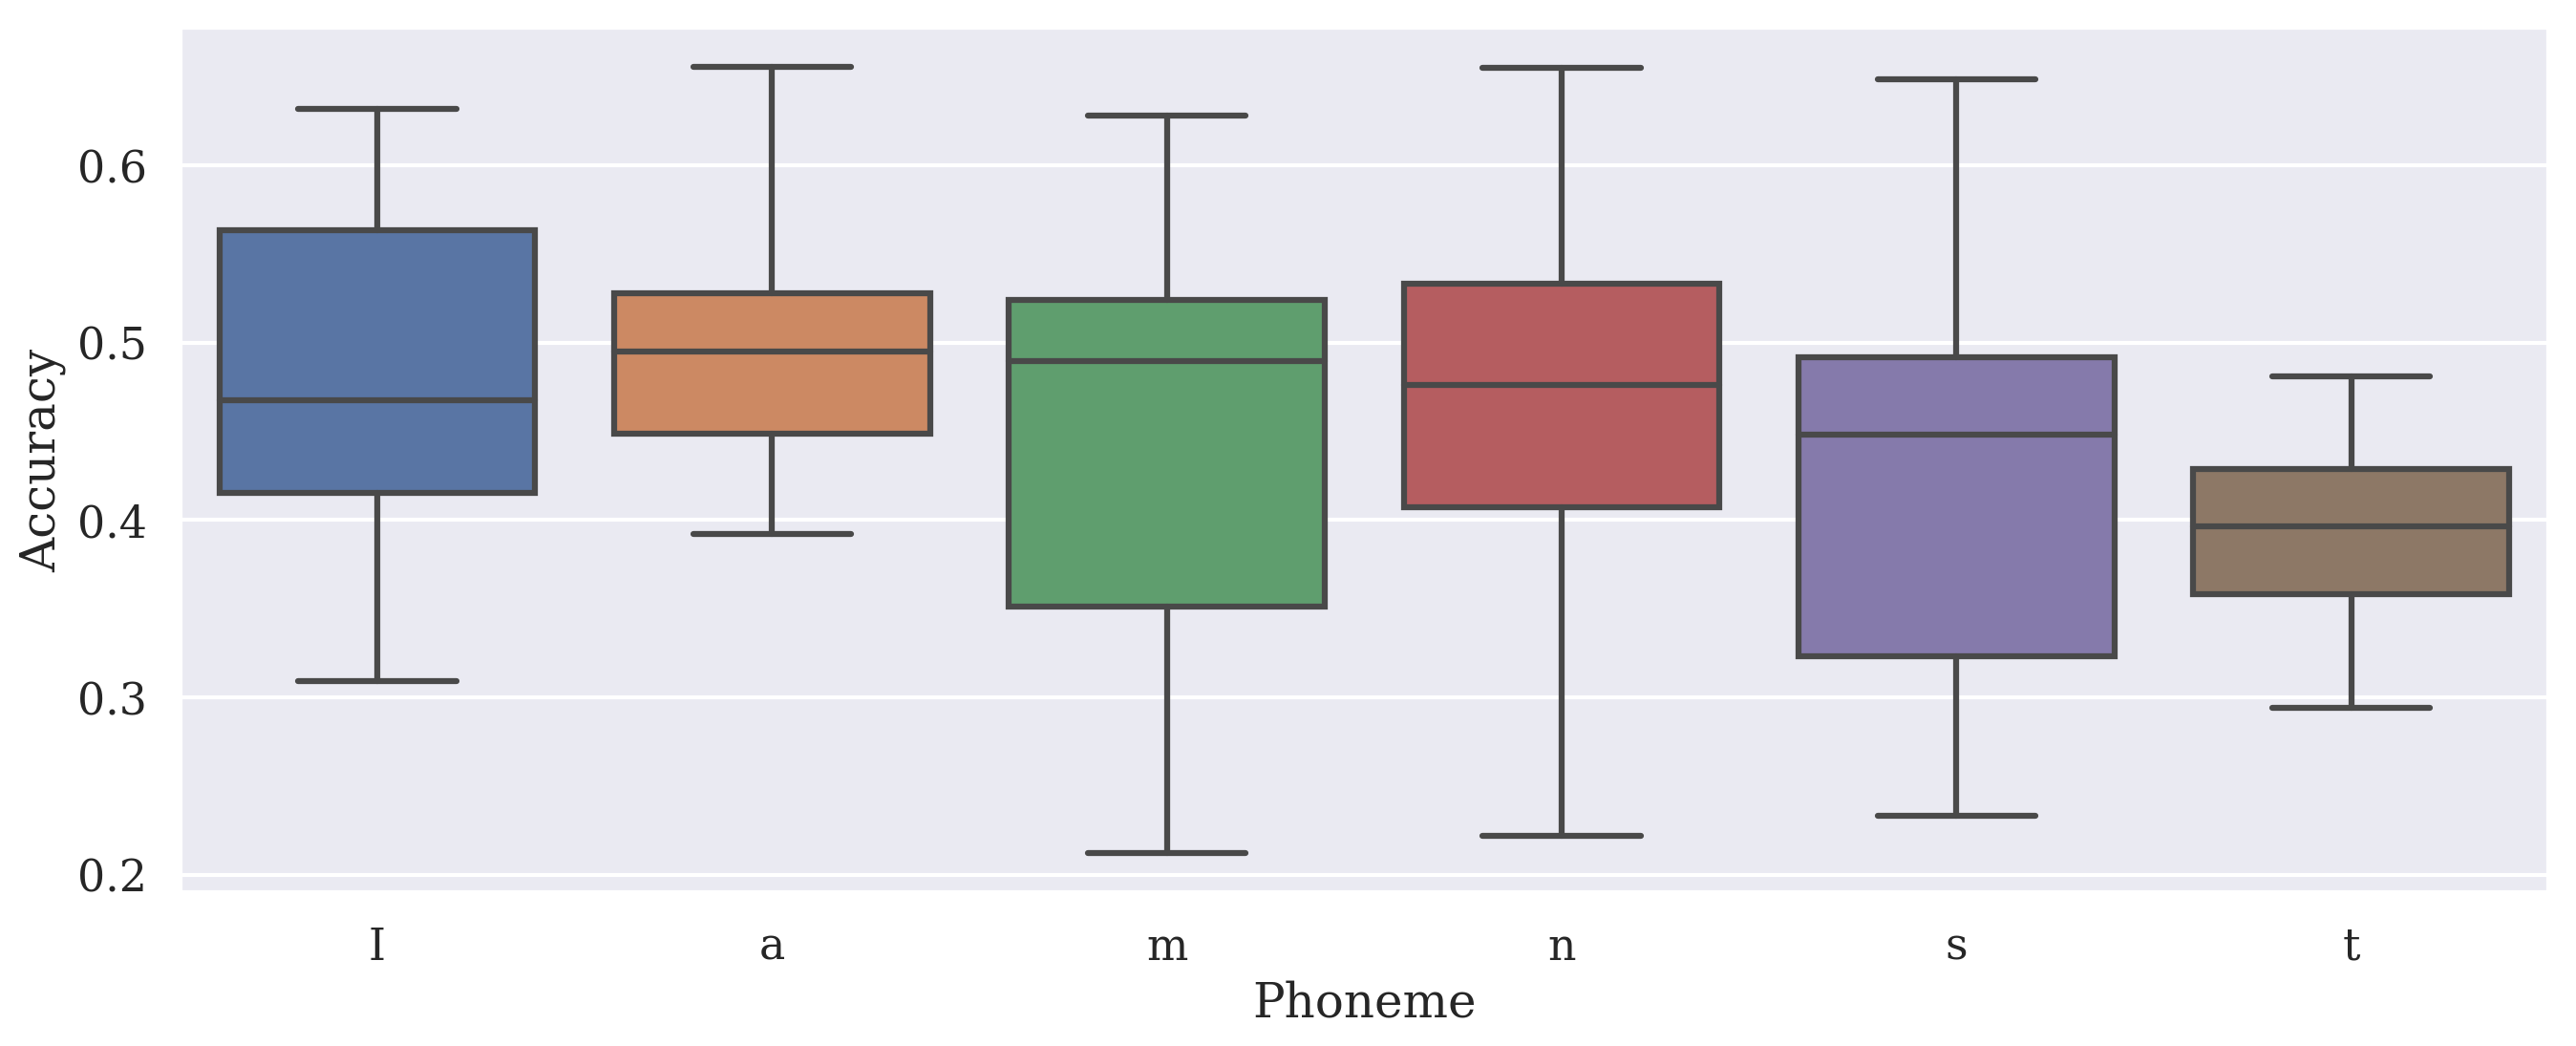

In [216]:
sns.set_context('talk')
plt.figure(figsize=(16,6),dpi=200)
sns.boxplot(x='Phoneme',y='Accuracy',whis=2,data=pd.melt(df,id_vars='index',var_name='Phoneme',value_name='Accuracy'))